# Angular Correlations of Amorphous Materials
This notebook walks you through caclulating the angular correlation for an amorphous(or crystalline) material using pyXEM.  As of the time of this writing this code had been tested using pyxem version 0.11. If you have any issues/erros with running this jupyter notebook feel free to submit an issue request to the [github repo](https://github.com/pyxem/pyxem-demos). 

In order to run this notebook you first need to have the data downloaded and saved it in the same folder as the jupyter notebook.  If not you will need to change the data_path varible below to match the location of the dataset on your computer. 

The dataset that is shown below is a 4-D STEM dataset of a PdNiP deposited thin film glass aquired using a DE-16 Camera and a 200keV FEI-Titan electron microscopt at 100 fps.  The probe size was ~2-nm and step size was .365 nm.  **Note: This means that there is singificant overlap in the probe positions.**

1. <a href='#loa'> Importing & Visualization</a>
2. <a href='#s2'> Polar Reprojection</a>
3. <a href='#s3'> Angular Correlation</a>
4. <a href='#s4'> Power Spectrum and Correlation Maps</a>

 #  <a id='loa'></a> 1 - Importing and Visualization

In [1]:
import hyperspy.api as hs  # no need to import pyxem as hyperspy will auto-load pyxem

/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(hs.print_known_signal_types()) # Showing which additional modules are loaded 
# A series of signals associated with the pyxem package should be listed.  If not 
# you should make sure you have properly downloaded pyxem

+----------------------------+---------------------+----------------------------+----------+
|        signal_type         |       aliases       |         class name         | package  |
+----------------------------+---------------------+----------------------------+----------+
|        correlation         |                     |       Correlation2D        |  pyxem   |
|     CorrelationSignal      |                     |     CorrelationSignal      |  empyer  |
|            dpc             |                     |       DPCBaseSignal        |  pyxem   |
|            dpc             |                     |        DPCSignal1D         |  pyxem   |
|            dpc             |                     |        DPCSignal2D         |  pyxem   |
|     DielectricFunction     | dielectric function |     DielectricFunction     | hyperspy |
|        diffraction         |                     |       Diffraction1D        |  pyxem   |
|        diffraction         |                     |       Diffraction

In [3]:
data_path = "data/09/PdNiP_test.hspy"

In [4]:
data = hs.load(data_path)

In [5]:
data.axes_manager

<Axes manager, axes: (40, 40|64, 64)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     40 |      0 |       0 |    0.23 |     nm 
               y |     40 |      0 |       0 |    0.23 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              kx |     64 |        |   0.074 |    0.16 | $nm^{-1}$ 
              ky |     64 |        |   0.074 |    0.16 | $nm^{-1}$

 #  <a id='s2'></a> 2 - Polar Reprojection
 
This section deals with converting the signal to a polar signal.  This is probably the most important and difficult part of the analysis.  Even small distortions in the pattern or misinterpertation of the center of the diffraction pattern will negitively affect the ability to determine correlations.

There is still some ongoing development on methods for identifying and correcting for these distortions but a good check is always to perform the correct and make sure that the first amorphous ring is a line after the polar reprojection.  In general your eye should be very good at identifying that.  Another thing to notice is that after the correlation if you have small splititing in all of your peaks(especially the self correlation) then most likely your center isn't completely correct.

In [19]:
data.set_signal_type("electron_diffraction")
data.beam_energy=200
data.unit = "k_nm^-1"
data.set_ai(center=(31.77734804))
rad = data.get_azimuthal_integral2d(npt=100)

**Note:** This isn't perfect, as you can see there is still some distortion that an affine transformation could fix, but for the purposes of this demo this is sufficently good

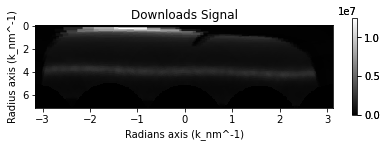

In [20]:
rad.sum().plot()

 #  <a id='s3'></a> 3 - Angular Correlations
 
This section deals with converting the signal to a correlation signal.  The most important part here is to properly mask the data.  This is important for example if you have a beam stop

In [21]:
import numpy as np
mask = np.zeros((100,360), dtype=bool)

In [12]:
mask[0:20,:]=True
mask[:,0:20]=True
mask[:,-20:]=True

In [13]:
import matplotlib.pyplot as plt

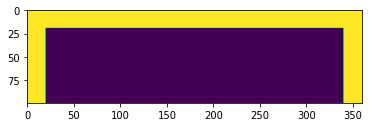

In [14]:
plt.imshow(mask)
plt.show()

In [15]:
cor = rad.get_angular_correlation(mask = mask)

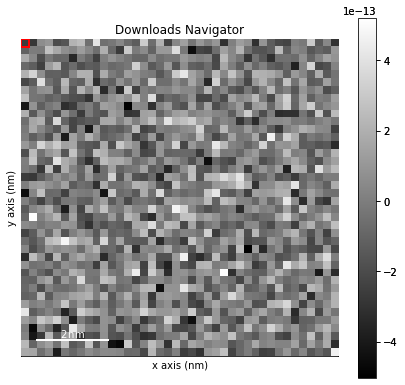

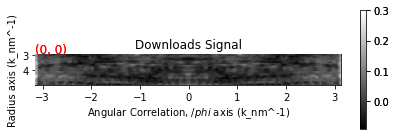

In [16]:
cor.isig[:,3.0:5.0].plot()

 #  <a id='s4'></a> 4 - Power Spectrum and Correlation Maps
 
This section deals with visualization of the correlations as correlation maps.  These are spatial maps of the strucutre in some material. 

In [17]:
power = cor.get_angular_power()

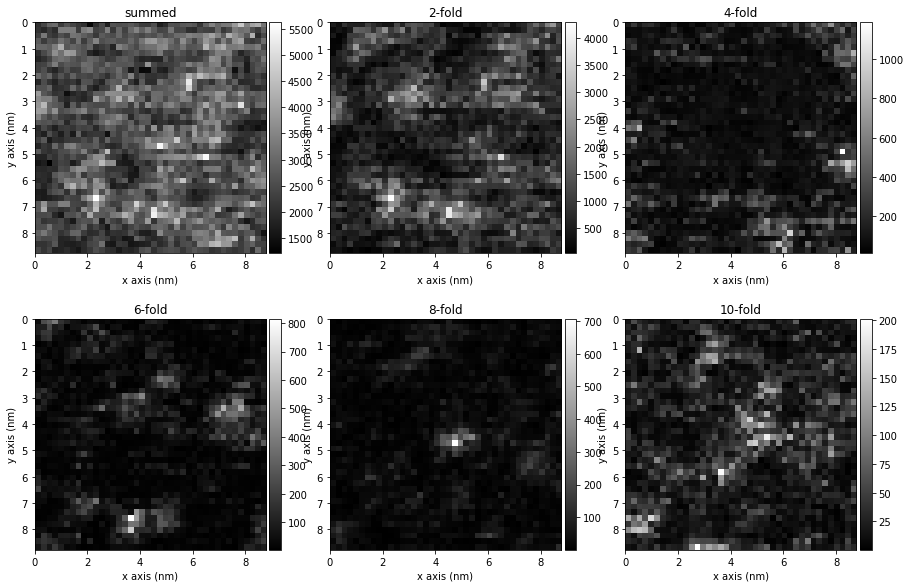

In [18]:
f = plt.figure(figsize=(15,10))
power.plot_symmetries(k_region = [3.5,5.0],fig=f)